In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.ticker import AutoMinorLocator
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.signal import find_peaks
# from nolds import lyap_r
from scipy.integrate import solve_ivp
from functools import partial


plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'figure.autolayout': True})


# Data for Fig. S4(a,b)

In [ ]:
N_list=[50,75,100]
for N in N_list:
    sx,sy,sz=jmat(N)
    sm=jmat(N,'-')
    sp=jmat(N,'+')
    I=qeye(2*N+1)

    Ω=1.45
    U=0.25
    κ=1
    nth=0
    H=Ω*(sx)+2*U*(sz**2)/(N)
    c_ops=[np.sqrt(κ*(1+nth)/N)*sm,np.sqrt(κ*(nth)/N)*sp]

    r0=np.zeros(2*N+1)
    r0[0]=1
    psi0=Qobj(r0)
    times=np.linspace(0,100,1000)
    sol=mcsolve(H,psi0,times,c_ops,[sz],ntraj=1600)
    np.savetxt('sol_U025_O145_S_'+str(N)'.out',sol.expect, delimiter=' ')

# Plotting Fig. S4(a,b)

In [8]:
# Time crystal phase
solt_S_n50=np.loadtxt('sol_U025_O145_S_50.out',delimiter=' ')
solt_S_n75=np.loadtxt('sol_U025_O145_S_75.out',delimiter=' ')
solt_S_n100=np.loadtxt('sol_U025_O145_S_100.out',delimiter=' ')

In [11]:
def BTC(m, t, p):
    """
    Defines the system of differential equations.
    
    Arguments:
        w : vector of the state variables
            w = [mx, my, mz]
        t : time
        p : parameter
    """
    
    m1, m2, m3 = m
    detuning, ωx, ωz = p
    
    f = [ -2*ωz*m2*m3 + m1 * m3,
         2*ωz*m1*m3 - ωx * m3 + m2 * m3,
         ωx * m2 - m1**2 - m2**2]
    
    return f

detuning, ωx, ωz = 0, 1.45, 0.5
p01= [detuning, ωx, ωz]
m0 = [0,0,1]

f_s = 20                              # number of time steps
end = 1000                           # final time
time_mf = np.linspace(0.0, end, end*f_s)

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 10.0
numpoints = 250


#Time crystal phase
msol_tc = odeint(BTC, m0, time_mf , args=(p01,), atol=abserr, rtol=relerr)

# Melted phase
msol_mel = odeint(BTC, m0, time_mf , args=([0, 0.8, 0.5],), atol=abserr, rtol=relerr)


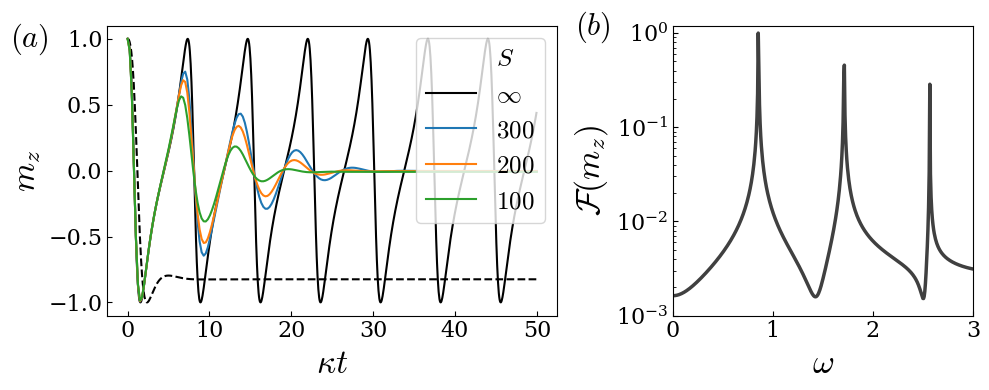

In [12]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'serif'


time = np.linspace(0.0, 50, 200)

def fourier_transform(data, dt):
    n = len(data)
    fft_result = np.fft.fft(data)
    fft_freq = 2*np.pi*np.fft.fftfreq(n, dt)
    return fft_freq, fft_result
    
fft_freqA0, fft_resultA0 = fourier_transform(msol_tc[:,2], 1/f_s)

fig, ax = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'width_ratios': [1,2/3]})
k=0

ax[k].plot(time,solt_S_n100/100,'w.',label=r'$S$')
ax[k].plot(time_mf[0:1000],msol_tc[0:1000,2],'k-',label=r'$\infty$')
ax[k].plot(time_mf[0:1000],msol_mel[0:1000,2],'k--')

ax[k].plot(time,solt_S_n300/300,label='$300$')
ax[k].plot(time,solt_S_n200/200,label='$200$')
ax[k].plot(time,solt_S_n100/100,label='$100$')

ax[k].set_ylabel(r'$m_z$', fontsize=24)
ax[k].set_xlabel(r'$\kappa t$', fontsize=24)
ax[k].tick_params(which='both', direction='in', labelsize=16)
ax[k].legend(loc='upper right', fontsize=18)#, title=r'$\Omega/\kappa$')
ax[k].set_ylim(-1.1,1.1)
# ax[k].set_ylim(-y_lim,y_lim)
# ax[k].set_xlim(x_in,x_f)
k=1
ax[k].semilogy(fft_freqA0, np.abs(fft_resultA0)/np.max(np.abs(fft_resultA0)), 'k', lw=2.5, alpha=0.75)
ax[k].set_xlabel(r'$\omega$', fontsize=24)
ax[k].set_ylabel(r'$\mathcal{F}(m_z)$', fontsize=24)
ax[k].tick_params(which='both', direction='in', labelsize=16)
ax[k].set_xlim(0,3)
ax[k].set_ylim(0.001,1.2)

ax[0].text(
    -12, 1,  # Position (x, y) in figure coordinates
    r'$(a)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22  # Font size
#     color='white'
)

ax[1].text(
    -0.8, 1.14,  # Position (x, y) in figure coordinates
    r'$(b)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22  # Font size
#     color='white'
)

plt.tight_layout()
# plt.savefig('spin_mz.svg',dpi=300)

plt.show()